In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv('../data/cleaned_players.csv', index_col = 0)
df.head()

,id_players,player_name,birthday,height,weight,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,67.0,71.0,right,medium,medium,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
5,2,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,74.0,76.0,left,high,medium,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
47,3,Aaron Doran,1991-05-13 00:00:00,170.18,163,71.0,78.0,right,medium,medium,...,72.0,63.0,22.0,21.0,21.0,15.0,10.0,11.0,8.0,12.0
83,4,Aaron Galindo,1982-05-08 00:00:00,182.88,198,75.0,82.0,right,medium,high,...,54.0,60.0,80.0,78.0,70.0,14.0,11.0,65.0,11.0,10.0
106,5,Aaron Hughes,1979-11-08 00:00:00,182.88,154,78.0,81.0,right,medium,medium,...,60.0,81.0,82.0,83.0,77.0,12.0,20.0,57.0,20.0,20.0


## Question 4 

Question: Are there distinct player types based on specific clusters? How do these types affect team dynamics?

Rationale: This client in team management could use this to balance and optimize the team.

In [19]:
# Define attribute groups
attacking_attrs = ['finishing', 'shot_power', 'volleys', 'dribbling', 'ball_control', 'acceleration', 'sprint_speed']
midfield_attrs = ['short_passing', 'ball_control', 'vision', 'stamina', 'interceptions']
defensive_attrs = ['marking', 'standing_tackle', 'sliding_tackle', 'interceptions', 'strength']
goalkeeper_attrs = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

In [20]:
# Combine all attributes for clustering
all_attrs = list(set(attacking_attrs + midfield_attrs + defensive_attrs + goalkeeper_attrs))

# Prepare data for clustering
X = df[all_attrs]

In [21]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering (k=9 for 3 positions × 3 styles)
kmeans = KMeans(n_clusters=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate mean values for each cluster
cluster_means = df.groupby('Cluster')[all_attrs].mean()

In [22]:
# Function to identify cluster characteristics
def identify_cluster_type(cluster_means_row):
    attack_score = cluster_means_row[attacking_attrs].mean()
    midfield_score = cluster_means_row[midfield_attrs].mean()
    defense_score = cluster_means_row[defensive_attrs].mean()
    goalkeeper_score = cluster_means_row[goalkeeper_attrs].mean()
    
    
    if goalkeeper_score > 50:  
        return "Goalkeeper"
    
    # For other positions
    scores = [attack_score, midfield_score, defense_score]
    max_score = max(scores)
    
    if max_score == attack_score:
        position = "Forward"
    elif max_score == midfield_score:
        position = "Midfielder"
    else:
        position = "Defender"
        
    if attack_score > defense_score:
        style = "Attacking"
    elif defense_score > attack_score:
        style = "Defensive"
    else:
        style = "Balanced"
        
    return f"{position} ({style})"

In [23]:
cluster_means = df.groupby('Cluster')[all_attrs].mean()
cluster_types = {}
for cluster in range(10):
    cluster_types[cluster] = identify_cluster_type(cluster_means.loc[cluster])

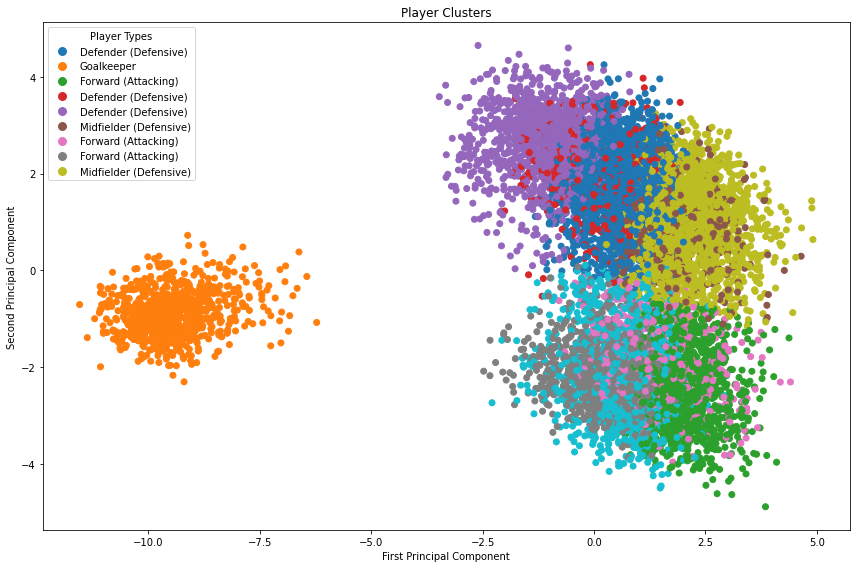

In [24]:
# Add position and style labels to dataframe
df['Player_Type'] = df['Cluster'].map(cluster_types)

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='tab10')
plt.title('Player Clusters')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=scatter.cmap(scatter.norm(i)),
                            label=cluster_types[i], markersize=10)
                  for i in range(9)]
plt.legend(handles=legend_elements, title='Player Types')
plt.tight_layout()
plt.show()

In [26]:
# Print top 10 players from each cluster sorted by overall rating
for cluster in range(9):
    print(f"\n\nCluster {cluster} - {cluster_types[cluster]}:")
    print("-" * 50)
    
    # Get top 10 players from this cluster
    cluster_players = df[df['Cluster'] == cluster].nlargest(10, 'overall_rating')
    
    # Display player names and key attributes based on position type
    if cluster_types[cluster].startswith('Forward'):
        relevant_attrs = attacking_attrs
    elif cluster_types[cluster].startswith('Midfielder'):
        relevant_attrs = midfield_attrs
    else:
        relevant_attrs = defensive_attrs
    
    # Print players and their key attributes
    display_cols = ['player_name', 'overall_rating'] + relevant_attrs
    print(cluster_players[display_cols].to_string())



Cluster 0 - Defender (Defensive):
--------------------------------------------------
              player_name  overall_rating  marking  standing_tackle  sliding_tackle  interceptions  strength
64465   Giorgio Chiellini            87.0     91.0             91.0            91.0           87.0      89.0
43950         Diego Godin            86.0     86.0             86.0            89.0           86.0      78.0
11443     Andrea Barzagli            85.0     90.0             90.0            88.0           92.0      85.0
121945      Mehdi Benatia            85.0     90.0             89.0            87.0           90.0      86.0
127004            Miranda            85.0     89.0             90.0            89.0           88.0      80.0
142277               Pepe            85.0     85.0             88.0            93.0           85.0      84.0
99527   Laurent Koscielny            84.0     83.0             87.0            85.0           85.0      73.0
133067   Nicolas Otamendi            84.0

Now we can search for players inside their cluster depending on the attribute we want to look for to improve our team 

In [ ]:
def find_random_player_by_style(position, style=None, df=df, cluster_types=cluster_types):

    # Get matching clusters based on position and style
    matching_clusters = []
    for cluster, type_name in cluster_types.items():
        if position == 'Goalkeeper' and type_name == 'Goalkeeper':
            matching_clusters.append(cluster)
        elif position in type_name and (style is None or style in type_name):
            matching_clusters.append(cluster)
    
    if not matching_clusters:
        return f"No players found for {position} {style if style else ''}"
    
    # Get players from matching clusters
    matching_players = df[df['Cluster'].isin(matching_clusters)]
    
    # Select random player
    random_player = matching_players.sample(n=1)
    
    # Get relevant attributes
    if position == 'Goalkeeper':
        relevant_attrs = goalkeeper_attrs
    elif position == 'Forward':
        relevant_attrs = attacking_attrs
    elif position == 'Midfielder':
        relevant_attrs = midfield_attrs
    else:
        relevant_attrs = defensive_attrs
    
    display_cols = ['player_name', 'overall_rating'] + relevant_attrs
    return random_player[display_cols]

In [28]:
print("Random Attacking Forward:")
print(find_random_player_by_style('Forward', 'Attacking'))

Random Attacking Forward:
         player_name  overall_rating  finishing  shot_power  volleys  \
52931  Fabian Vargas            76.0       67.0        68.0     64.0   

       dribbling  ball_control  acceleration  sprint_speed  
52931       76.0          77.0          72.0          76.0  


In [29]:
print("\nRandom Defensive Midfielder:")
print(find_random_player_by_style('Midfielder', 'Defensive'))


Random Defensive Midfielder:
         player_name  overall_rating  short_passing  ball_control  vision  \
154367  Ruben Micael            79.0           86.0          80.0    85.0   

        stamina  interceptions  
154367     75.0           70.0  


In [51]:
print("\nRandom Goalkeeper:")
print(find_random_player_by_style('Goalkeeper'))


Random Goalkeeper:
       player_name  overall_rating  gk_diving  gk_handling  gk_kicking  \
35542  Daniel Haas            72.0       73.0         71.0        58.0   

       gk_positioning  gk_reflexes  
35542            69.0         78.0  
